# Отдел аналитики Яндекс.Афиши. 
Задание: оптимизировать маркетинговые затраты.
Данные от Яндекс.Афиши 
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt
from math import *
import seaborn as sns

### 1 Загрузка данных и подготовка к анализу

In [2]:
visits_log = pd.read_csv('/datasets/visits_log.csv')
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
visits_log.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits_log.duplicated().sum()

0

In [5]:
orders_log = pd.read_csv('/datasets/orders_log.csv')
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [6]:
orders_log.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [7]:
orders_log.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [8]:
orders_log.duplicated().sum()

0

In [9]:
costs = pd.read_csv('/datasets/costs.csv')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [10]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [11]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [12]:
costs.duplicated().sum()

0

In [13]:
visits_log['End Ts'] = pd.to_datetime(visits_log['End Ts'], format = '%Y-%m-%d %H:%M')
visits_log['Start Ts'] = pd.to_datetime(visits_log['Start Ts'], format = '%Y-%m-%d %H:%M')

orders_log['Buy Ts'] = pd.to_datetime(orders_log['Buy Ts'], format = '%Y-%m-%d %H:%M')

costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d')

In [14]:
visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders_log.columns = ['buy_ts', 'revenue', 'uid']

#### Выводы
Bсе графы, содержащие данные о датах и времени, сохранены в формате 'object'. Это затруднит работу с данными. 
Данные с датами приведены в формат 'datetime64'.

Пропусков в данных нет.

Дубликаты во всех трех датафреймах отсутствуют.

Названия столбцов приведены к одному типу: только маленькие буквы, вместо пробелов введен знак "_".

### 2.  Построение отчётов и рассчёт метрик

### О продукте

In [15]:
visits_log['session_duration'] = (visits_log['end_ts'] - visits_log['start_ts']) / np.timedelta64(1, 's')
visits_log['session_duration'].describe()

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration, dtype: float64

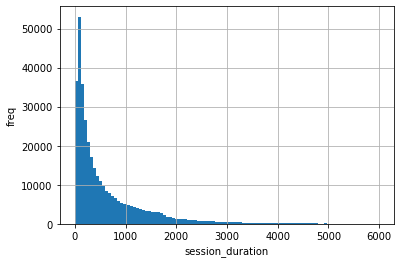

In [16]:
plt.xlabel("session_duration")
plt.ylabel("freq")
visits_log['session_duration'].hist(range = (0, 6000), bins = 100)

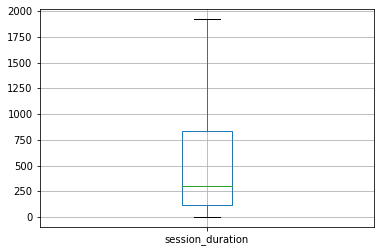

In [17]:
visits_log.boxplot('session_duration', showfliers=False)

In [18]:
filtered_visits_log = visits_log.query('session_duration > 0 and session_duration < 2700' )
print('Из исходных данных удалено', 100 - (filtered_visits_log.shape[0]*100/visits_log.shape[0]), '% данных')

Из исходных данных удалено 13.60072342793545 % данных


Из результата метода describe() видно, что 75% значений session duration находятся до отметки в 840 сек (14 мин). Из частотной диаграммы можно предположить, что сессии длиной более 5000 встречаются крайне редко. Метод boxplot() показывает, что выбросами можно считать значения 'session_duration' начиная с примерно 2000 сек.- это 45 минут. В итоге из датасета удалено 13.6% данных. Граница данных выбрана как 3 межквартильных интервала от медианы начальной таблицы visits_log 


In [19]:
minus_and_null_duration = visits_log.query('session_duration <= 0')
minus_and_null_duration.groupby('device')['session_duration'].count()

device
desktop    23691
touch      12105
Name: session_duration, dtype: int64

В датафрейме minus_and_null_duration сохранены логи посещений с отрицательной и нулевой длительностью - выяснить, где происходит ошибка, как получается, что время окончания сессии происходит раньше, чем само начало сессии.
Из гистограммы видно, что редко случаются сессии длиной более 5000 сек. Скорее всего здесь тоже имеет место ошибка. 
Для дальнейшего анализа будут взяты данные с длительностью сессии более 0 и менее 5000 сек. 

Разбираем данные о времени начала сессии на отдельные элементы (для последующий группировки):

In [20]:
filtered_visits_log['session_day'] = filtered_visits_log['start_ts'].dt.date # выделена дата
filtered_visits_log['session_month']= filtered_visits_log['start_ts'].astype('datetime64[M]') # дата округлена до начала месяца
filtered_visits_log['session_week'] = filtered_visits_log['start_ts'].dt.week # выделен номер недели
filtered_visits_log['session_year'] = filtered_visits_log['start_ts'].dt.year # выделен год


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [21]:
visits_log_group_week = filtered_visits_log.groupby(['session_year', 'session_week']).agg({'uid':['nunique', 'count']})
visits_log_group_week.columns = ['n_users', 'n_sessions']
visits_log_group_month = filtered_visits_log.groupby(['session_year', 'session_month']).agg({'uid':['nunique', 'count']})
visits_log_group_month.columns = ['n_users', 'n_sessions'] 
visits_log_group_day = filtered_visits_log.groupby('session_day').agg({'uid':['nunique', 'count']})
visits_log_group_day.columns = ['n_users', 'n_sessions']

Сгруппированы таблицы по времени (неделя, месяц, день), посчитаны количество уникальных пользователей и кол-во сессий за периоды.

In [22]:
print('Песетителей в день:', visits_log_group_day['n_users'].mean())
print('Песетителей в неделю:', visits_log_group_week['n_users'].mean())
print('Песетителей в месяц:', visits_log_group_month['n_users'].mean())

Песетителей в день: 794.2802197802198
Песетителей в неделю: 5036.509433962264
Песетителей в месяц: 20551.416666666668


In [23]:
print('Сессий в день:', visits_log_group_day['n_sessions'].mean())

Сессий в день: 853.0741758241758


In [24]:
print('Средняя длительность сессии:',filtered_visits_log['session_duration'].mode())

Средняя длительность сессии: 0    60.0
dtype: float64


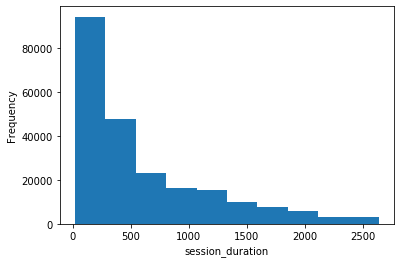

Визитов с desktop за год 227484
Среднее время сессии с устройства типа desktop: 596.3061402120588


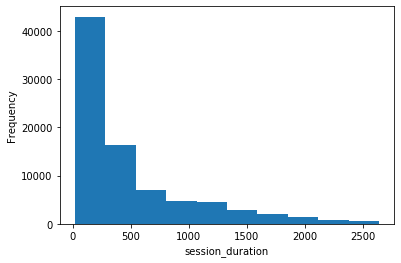

Визитов с touch за год 83035
Среднее время сессии с устройства типа touch: 476.57260191485517


In [25]:
desktop = filtered_visits_log.query('device == "desktop"')
plt.xlabel("session_duration")
plt.ylabel("frequency")
desktop['session_duration'].plot(kind = 'hist')
plt.show()
print('Визитов с desktop за год', len(desktop))
print('Среднее время сессии с устройства типа desktop:', desktop['session_duration'].mean() )
touch = filtered_visits_log.query('device == "touch"')
plt.xlabel("session_duration")
plt.ylabel("frequency")
touch['session_duration'].plot(kind = 'hist')
plt.show()
print('Визитов с touch за год', len(touch))
print('Среднее время сессии с устройства типа touch:', touch['session_duration'].mean() )

Из гистограмм видно, что с device типа touch на ресурсе проводят меньше времени и заходят реже.

##### 1. О пользователях

In [26]:
first_session = filtered_visits_log.groupby('uid').agg({'start_ts' : 'min'})
first_session.columns = ['first_session_date'] #посчитана первая сессия, когда каждый пользователь появился на ресурсе

In [27]:
filtered_visits_log  = pd.merge(filtered_visits_log, first_session, on = 'uid' ) # для всех пользователей из таблицы добавлена первая сессия 

Учитывая большой промежуток анализируемых данных (календарный год) формируем когорты пользователей исходя из даты их первого визита по месяцам.

In [28]:
filtered_visits_log['first_activity_month'] = filtered_visits_log['first_session_date'].astype('datetime64[M]')

In [29]:
filtered_visits_log['lifetime'] = ((filtered_visits_log['session_month'] - filtered_visits_log['first_activity_month'])) / np.timedelta64(1, 'M')
filtered_visits_log['lifetime'] = filtered_visits_log['lifetime'].round().astype('int') # вычисляем месяц жизни когорты, 
# к которой принадлежит пользоалель. И округляем до целого,поскольку шаг когорты - 1 месяц

In [30]:
cohort_an = filtered_visits_log.pivot_table(index='first_activity_month',
    columns='lifetime',
    values='uid',
    aggfunc='nunique')

first_month_dif = cohort_an[0]/cohort_an[1]
first_month_dif.mean()

16.88402186216302

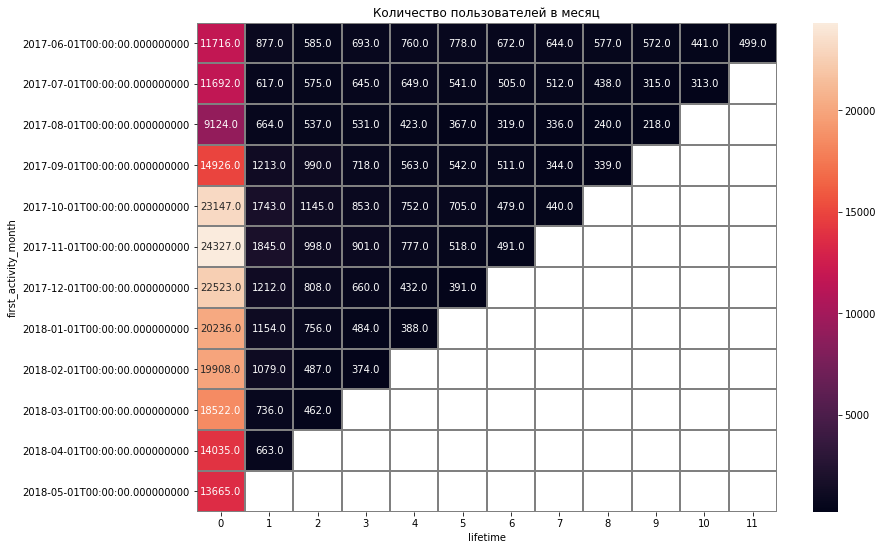

In [31]:
plt.figure(figsize=(13, 9))
plt.title('Количество пользователей в месяц')
sns.heatmap(cohort_an, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

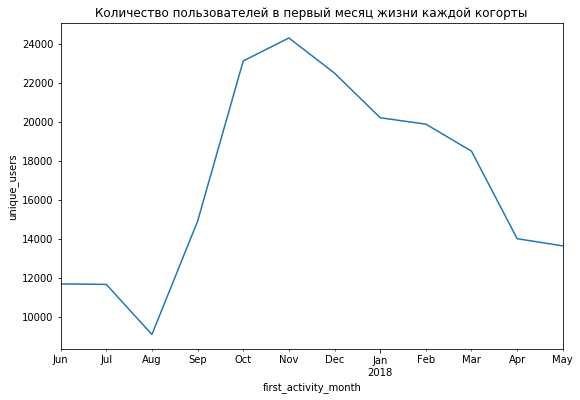

In [32]:
plt.figure(figsize=(9, 6))
plt.title('Количество пользователей в первый месяц жизни каждой когорты')
plt.xlabel("first_activity_month")
plt.ylabel("unique_users")
cohort_an[0].plot()

Из сводной таблицы видно, что в первыq месяц 'lifetime'  количество уникальных пользователей в среднем 16.8 раз больше, чем во второй для каждой когорты. 
Так же видно, что с октября 2017 по март 2018 - пользователей было очевидно больше, чем в оставшиеся (более 20 тыс уникальных пользователей). Пик интереса приходится на октябрь и ноябрь 2017.

##### 2. Коэффициент удержания (Retention Rate)

In [33]:
cohorts = filtered_visits_log.groupby(['first_activity_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
initial_users_count # получены размеры каждой когорты в первый месяц жизни

,first_activity_month,cohort_users
0,2017-06-01,11716
12,2017-07-01,11692
23,2017-08-01,9124
33,2017-09-01,14926
42,2017-10-01,23147
50,2017-11-01,24327
57,2017-12-01,22523
63,2018-01-01,20236
68,2018-02-01,19908
72,2018-03-01,18522


In [34]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='lifetime',values='retention',aggfunc='sum')

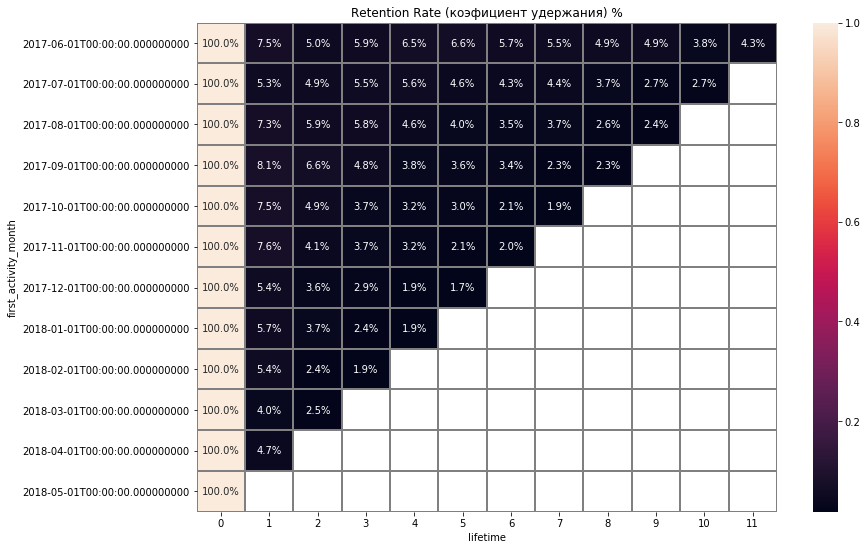

In [35]:
plt.figure(figsize=(13, 9))
plt.title('Retention Rate (коэфициент удержания) %')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Коэфициент удержания (Retention Rate, %) очень низкий. Это связано с тем, что большое число пользователей, привлеченных в первый месяц не возвращается. Количество посетителей, пользующихся 2ой месяц и более в 16 раз меньше тех, ко приходит в первый месяц. 
Можно предположить, что основная проблема не в привлечении новых клиентов, а в очень низкой конверсии посетителей в клиентов. 

##### 3. Коэффициент оттока (Churn Rate)

In [36]:
cohorts['churn_rate'] = cohorts.groupby(['first_activity_month'])['uid'].pct_change()

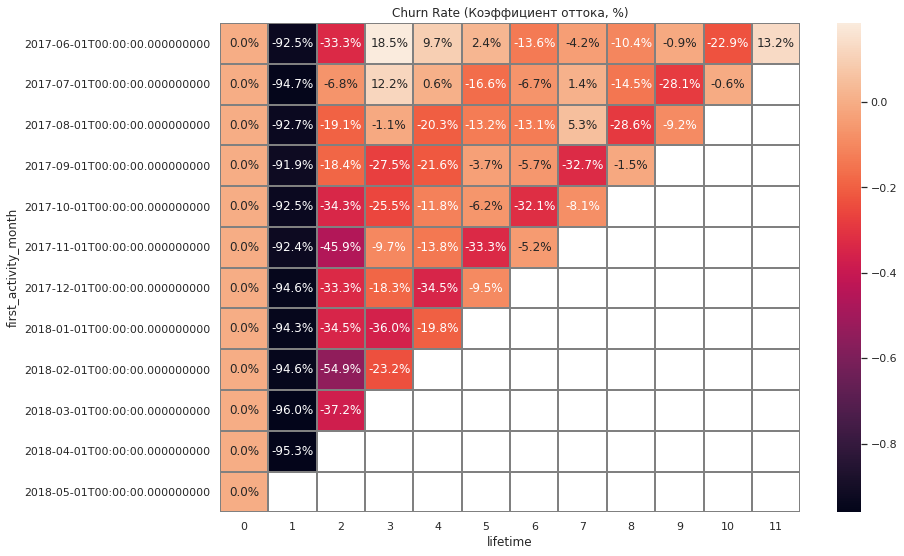

In [37]:
churn_pivot = cohorts.pivot_table(index='first_activity_month',columns='lifetime',values='churn_rate',aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Churn Rate (Коэффициент оттока, %)')
sns.heatmap(churn_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Коэффициент оттока (Churn Rate) показывает, что от месяца к месяцу коэффициент пользователей уменьшается. Положительных значений очень мало. 
Единственной когортой, показавшей рост количества пользователей в последний месяц (май 2018) - это самая старая когорта (июня 2017). Есть какой то бонус для пользователей, вернувшихся через год?
В апреле 2018 все когорты показали снижение количества пользователей - от 23,3 до 56,8%
Подтверждается предположение о проблеме удержаия пользователей. 

### О продажах

In [38]:
first_buy = orders_log.groupby('uid')['buy_ts'].min()
first_buy.name = 'first_session_date'
first_buy # дата первой покупки для каждого пользователя

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: first_session_date, Length: 36523, dtype: datetime64[ns]

In [39]:
orders_log = pd.merge(orders_log, first_session, on = 'uid') #для каждого пользователя внесено значение первого визита на сайт
orders_log


,buy_ts,revenue,uid,first_session_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00
...,...,...,...,...
48481,2018-05-31 23:43:00,3.67,1805512004303848280,2017-12-07 23:20:00
48482,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00
48483,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00
48484,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00


In [40]:
orders_log['first_session_month'] = orders_log['first_session_date'].astype('datetime64[M]')

In [41]:
orders_log['when_buy']= (orders_log['buy_ts'] - orders_log['first_session_date'])/ np.timedelta64(1, 'm')
orders_log = orders_log.query('when_buy > 0 and buy_ts < "2018-06-01"') # убираем из среза тех, 
# чьи покупки были совершены раньше первой сессии, и тех, чьи покупки выходят за границу исследуемого периода. 
orders_log

,buy_ts,revenue,uid,first_session_date,first_session_month,when_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01,1.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01,11.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01,2.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01,15.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01,27.0
...,...,...,...,...,...,...
48480,2018-05-31 23:42:00,0.92,15854392578508828030,2018-05-31 23:26:00,2018-05-01,16.0
48481,2018-05-31 23:43:00,3.67,1805512004303848280,2017-12-07 23:20:00,2017-12-01,252023.0
48482,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-01,879.0
48483,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-01,2.0


0    1.0
dtype: float64


count     45145.000000
mean      56441.358977
std      103696.183779
min           1.000000
25%           7.000000
50%         701.000000
75%       64836.000000
max      524669.000000
Name: when_buy, dtype: float64

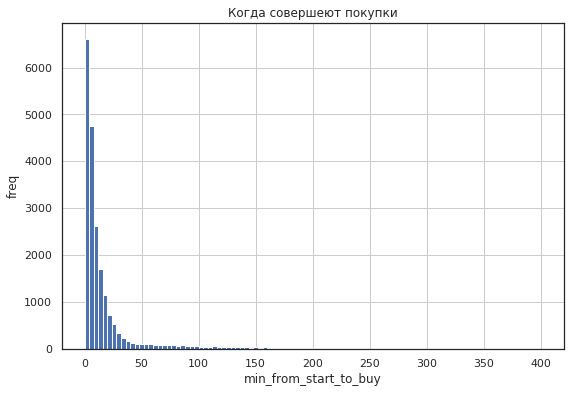

In [42]:
print(orders_log['when_buy'].mode())

plt.figure(figsize=(9, 6))
plt.title('Когда совершеют покупки')
orders_log['when_buy'].hist(bins = 100, range = (0, 400))
plt.xlabel("min_from_start_to_buy")
plt.ylabel("freq")
orders_log['when_buy'].describe()

Подавляющее большинство покупок совершается в первый день после регистрации (медиана пролегает на 382 минуте после первого визита). А метод mode() показывает, что большинство покупок совершается в первую минуту после регистрации. 

In [43]:
orders_log['buy_month'] = orders_log['buy_ts'].astype('datetime64[M]')
order_pivot = orders_log.pivot_table(index = 'first_session_month', columns = 'buy_month', values = 'revenue', aggfunc = 'mean')

display(order_pivot)
print('Средний чек за весь период', orders_log['revenue'].mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_session_month,,,,,,,,,,,,
2017-06-01,4.081997,7.129440,5.273977,8.841714,7.421889,6.469927,7.038426,6.977814,6.403418,11.176091,12.209885,5.185950
2017-07-01,NaN,5.008002,5.917500,5.644211,5.710476,4.878534,4.473314,4.445000,4.964931,5.009343,7.021348,5.987907
2017-08-01,NaN,NaN,4.562198,4.665896,5.597760,5.215305,5.730064,5.482921,4.308085,8.806115,10.296795,4.653247
2017-09-01,NaN,NaN,NaN,4.567075,7.579872,6.408026,38.838226,9.408222,10.280761,4.962350,5.076042,3.728411
2017-10-01,NaN,NaN,NaN,NaN,4.301493,6.138554,3.726458,4.663056,4.139778,4.249694,4.326721,4.360903
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.176527,3.742580,3.646868,4.514503,3.582281,4.962195,3.859568
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.213885,3.762068,16.532063,20.909215,13.613571,11.113758
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.577910,4.303805,4.662469,3.202907,4.306387
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.661317,4.645854,5.275600,9.187634


Средний чек за весь период 5.068980839517111


In [44]:
buy_count = orders_log.groupby('buy_month')['revenue'].count()
print('Среднее количество покупок за месяц:', buy_count.mean())

Среднее количество покупок за месяц: 3762.0833333333335


buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
count,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000
mean,4.081997,6.068721,5.251225,5.929724,6.122298,5.547812,9.680422,5.245482,6.567629,7.191506,6.713489,5.470371
std,NaN,1.500083,0.677937,2.001273,1.376002,0.935752,12.912963,2.031981,4.249409,5.392433,3.636560,2.325634
min,4.081997,5.008002,4.562198,4.567075,4.301493,4.176527,3.726458,3.577910,3.661317,3.582281,3.202907,3.728411
25%,4.081997,5.538362,4.918088,4.641191,5.597760,4.962727,3.978232,3.733268,4.303805,4.348734,4.277300,3.997527
50%,4.081997,6.068721,5.273977,5.155053,5.710476,5.676930,4.473314,4.554028,4.514503,4.812409,5.076042,4.507075
75%,4.081997,6.599080,5.595739,6.443586,7.421889,6.340658,6.384245,5.856644,6.403418,7.856922,8.659072,5.504104
max,4.081997,7.129440,5.917500,8.841714,7.579872,6.469927,38.838226,9.408222,16.532063,20.909215,13.613571,11.113758


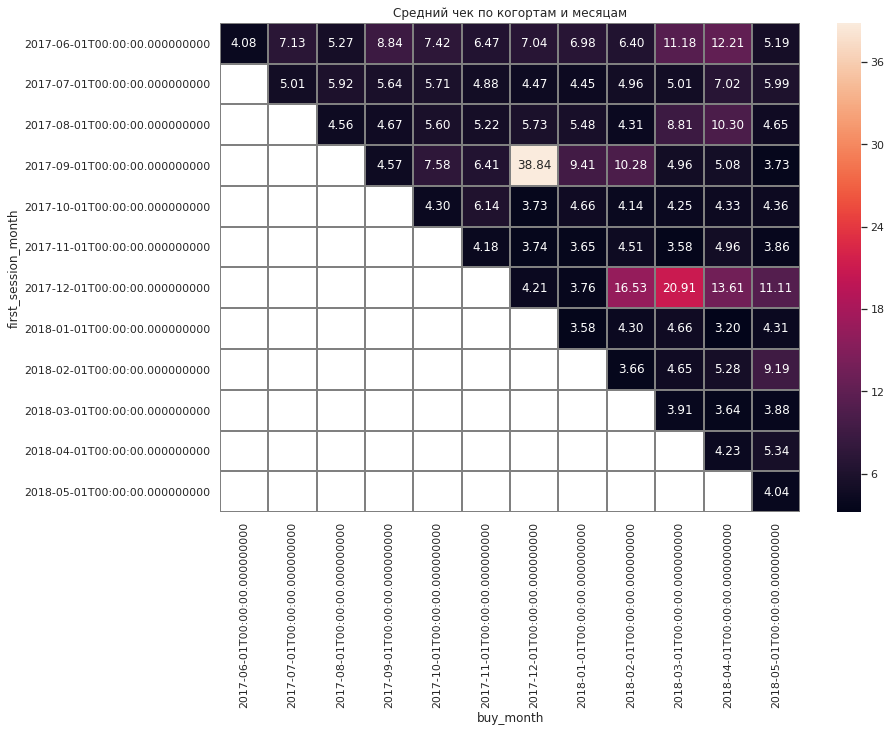

In [45]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Средний чек по когортам и месяцам')
sns.heatmap(order_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

order_pivot.describe()

Средний чек для всех когорт во все периоды коллеблется в диапазоне 3.7 - 8.7. Но есть исключения, например:
- самый высокий средний чек в декабру 2017 года для когорты 2017-09-01, 
- высокий средний чек для периода с 2018-02-01 по 2018-05-01 для когорты 2017-12-01.


In [46]:
first_orders = orders_log.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
cohort_sizes_orders = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes_orders.columns = ['first_order_month', 'n_buyers']
orders_new = pd.merge(orders_log,first_orders, on='uid')
cohorts_orders = orders_new.groupby(['first_order_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes_orders, cohorts_orders, on='first_order_month')

margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['buy_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']
print(report.head())

  first_order_month  n_buyers  buy_month  revenue       gp  age       ltv
0        2017-06-01      1776 2017-06-01  8278.29  8278.29    0  4.661199
1        2017-06-01      1776 2017-07-01   936.98   936.98    1  0.527579
2        2017-06-01      1776 2017-08-01   840.07   840.07    2  0.473012
3        2017-06-01      1776 2017-09-01  1884.14  1884.14    3  1.060890
4        2017-06-01      1776 2017-10-01  2021.90  2021.90    4  1.138457


In [47]:
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
display(output)
names = list(output.index)
print("Суммарный ltv за 6 мес. для когорт, проживших 6 и более месяцев")
for i in range(0, 6):
    a = names[i]
    print('Итоговый LTV для когорты', a, output.loc[a][6].sum())


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.661199,0.527579,0.473012,1.060890,1.138457,0.804364,1.019966,0.643148,0.593981,0.679172,0.627241,0.275878
2017-07-01,6.032488,0.371986,0.705981,0.401803,0.229876,0.205213,0.154456,0.178487,0.179125,0.185254,0.185934,NaN
2017-08-01,5.167458,0.520105,0.500694,0.423172,0.524633,0.306231,0.221719,0.429193,0.319814,0.205884,NaN,NaN
2017-09-01,5.313578,1.208677,0.539341,4.388036,0.445091,0.717767,0.777207,0.270343,0.203942,NaN,NaN,NaN
2017-10-01,4.972917,0.520567,0.195933,0.167347,0.155770,0.123233,0.093342,0.127008,NaN,NaN,NaN,NaN
2017-11-01,5.112294,0.468215,0.209580,0.364937,0.161813,0.054996,0.126606,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.723218,0.281600,1.038126,1.195027,0.354299,0.384490,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.099662,0.325378,0.325245,0.146945,0.070524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.173282,0.271836,0.086758,0.060807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Суммарный ltv за 6 мес. для когорт, проживших 6 и более месяцев
Итоговый LTV для когорты 2017-06-01 00:00:00 1.0199662162162162
Итоговый LTV для когорты 2017-07-01 00:00:00 0.1544562647754137
Итоговый LTV для когорты 2017-08-01 00:00:00 0.22171912832929785
Итоговый LTV для когорты 2017-09-01 00:00:00 0.7772072853425847
Итоговый LTV для когорты 2017-10-01 00:00:00 0.09334196220553978
Итоговый LTV для когорты 2017-11-01 00:00:00 0.126605504587156


По итоговым LTV видно, что когорта '2017-09-01' идет сразу за когортой '2017-06-01', несмотря на разницу в возрасте этих когорт.
Что стало причиной повышенного количества покупок для когорты '2017-09-01' в марте 2018 года? И почему с 3го месяца жизни клиенты этой когорты тратят больше денег, чем клиенты других когорт. 
Так же интересно, с чем связан пик покупок в декабре 2017 для когорты '2017-09-01'? (средний чек для этой когорты в декабре составил 38.8, при общем среднем чеке в 5.1 - возможно, была новогодняя акция?)

### Маркетинг

In [48]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

In [49]:
costs_grouped = costs.groupby(['costs_month', 'source_id']).agg({'costs' : 'sum'}).reset_index()
costs_grouped_pivot = costs_grouped.pivot_table(
        index = 'costs_month', 
        columns = 'source_id', 
        values = 'costs', 
        aggfunc = 'sum', 
        margins = True, 
        margins_name = 'total')


display(costs_grouped_pivot)

source_id,1,2,3,4,5,9,10,total
costs_month,,,,,,,,
2017-06-01 00:00:00,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22,18015.00
2017-07-01 00:00:00,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82,18240.59
2017-08-01 00:00:00,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57,14790.54
2017-09-01 00:00:00,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67,24368.91
2017-10-01 00:00:00,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24,36322.88
2017-11-01 00:00:00,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36,37907.88
2017-12-01 00:00:00,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86,38315.35
2018-01-01 00:00:00,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35,33518.52
2018-02-01 00:00:00,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88,32723.03


In [50]:
print('Всего денег потратили за год:', costs['costs'].sum())

Всего денег потратили за год: 329131.62


Больше всего денег за весь период вложено в ресурс 3.
Больше всего денег потрачено на маркетинг в декабре 2017. (Новогодние праздники) 
Счиатем, что маркетинг сработал по первому source_id, с которого зашел клиент.

In [51]:
source_first_list = filtered_visits_log.query('first_session_date.dt.date == session_day'). groupby('uid').agg({'source_id': 'first'})
source_first_list.columns = ['first_source_id']

orders_log = pd.merge(orders_log, source_first_list, on = 'uid')

In [52]:
source_revenue = orders_log.groupby(['first_session_month', 'buy_month', 'first_source_id']).agg({'revenue': 'sum', 'uid': 'nunique'}).reset_index()
first_month_revenue= source_revenue.query('first_session_month == buy_month')

In [53]:
first_month_revenue.columns =['first_session_month', 'month', 'source_id', 'revenue', 'n_buyers']
first_month_revenue

,first_session_month,month,source_id,revenue,n_buyers
0,2017-06-01,2017-06-01,1,1266.02,188
1,2017-06-01,2017-06-01,2,1402.52,208
2,2017-06-01,2017-06-01,3,1804.89,550
3,2017-06-01,2017-06-01,4,1680.68,345
4,2017-06-01,2017-06-01,5,1774.22,352
...,...,...,...,...,...
532,2018-05-01,2018-05-01,3,1775.81,540
533,2018-05-01,2018-05-01,4,2189.21,519
534,2018-05-01,2018-05-01,5,1556.61,365
535,2018-05-01,2018-05-01,9,81.90,27


In [54]:
costs_sum = costs.groupby(['source_id','costs_month'])['costs'].sum().reset_index()
costs_sum.columns = ['source_id', 'month', 'costs']

In [55]:
costs_per_order = pd.merge(first_month_revenue, costs_sum, on = ['source_id', 'month'])
costs_per_order['cost_per_user'] = costs_per_order['costs']/ costs_per_order['n_buyers']

In [56]:
costs_of_user = costs_per_order.pivot_table(index = 'month', columns = 'source_id', values = 'cost_per_user', margins = True)
costs_of_user

source_id,1,2,3,4,5,9,10,All
month,,,,,,,,
2017-06-01 00:00:00,5.987287,11.670096,14.057545,10.187826,7.432159,5.485000,3.879259,8.385596
2017-07-01 00:00:00,6.833631,15.052323,20.195711,8.344515,8.566114,10.084667,7.017447,10.870630
2017-08-01 00:00:00,10.694494,21.306471,22.340145,12.374462,7.118176,7.321471,6.840294,12.570788
2017-09-01 00:00:00,7.186651,16.051935,17.297830,12.392029,7.807586,7.841887,6.774559,10.764640
2017-10-01 00:00:00,7.125385,16.940559,19.215189,7.263394,7.403594,9.673175,3.755928,10.196746
2017-11-01 00:00:00,8.579509,19.292941,21.149491,6.295350,12.140768,9.109067,9.107586,12.239245
2017-12-01 00:00:00,7.385489,18.343820,19.081788,8.458667,10.230871,11.963273,11.330877,12.399255
2018-01-01 00:00:00,10.215794,23.490056,22.995000,8.112364,11.526867,14.788108,9.169403,14.328228
2018-02-01 00:00:00,9.109421,21.105377,19.464514,8.183324,10.162946,13.787500,5.226957,12.434291


In [57]:
source_revenue_pivot = source_revenue.pivot_table(index = 'buy_month', columns = 'first_source_id', values = 'revenue', aggfunc = 'sum', margins = True, margins_name = 'total')
source_revenue_pivot_total = source_revenue_pivot.query('buy_month == "total"')
costs_grouped_pivot_total = costs_grouped_pivot.query('costs_month == "total"')
source_month = costs.groupby('source_id')['dt'].min()
display(costs_grouped_pivot_total)  
display(source_revenue_pivot_total)
source_month

source_id,1,2,3,4,5,9,10,total
costs_month,,,,,,,,
total,20833.27,42806.04,141321.63,61073.6,51757.1,5517.49,5822.49,329131.62


first_source_id,1,2,3,4,5,9,10,total
buy_month,,,,,,,,
total,32538.03,43699.7,43778.25,49323.23,50395.55,5091.27,4013.11,228839.14


source_id
1    2017-06-01
2    2017-06-01
3    2017-06-01
4    2017-06-01
5    2017-06-01
9    2017-06-01
10   2017-06-01
Name: dt, dtype: datetime64[ns]

По итоговым суммам за год ресурсы с ID 3, 4, 9, 10 не окупились. В то время как ресурсы 1, 2, 5 вышли в плюс. Наибольший расход пока идет по ресурсу 3. При этом у ресурса 3 самая большая стоимость привелечения клиента - 18.7. Самая низкая стоимость клиента у ресурса 10 - 6.04. (из окупившихся к концу года ресурсов самая низкая стоимость привлечения клиента - у ресурса 1 - 7.76) При этом все ресурсы используются с начала исследуемого периода. 

Источник 1


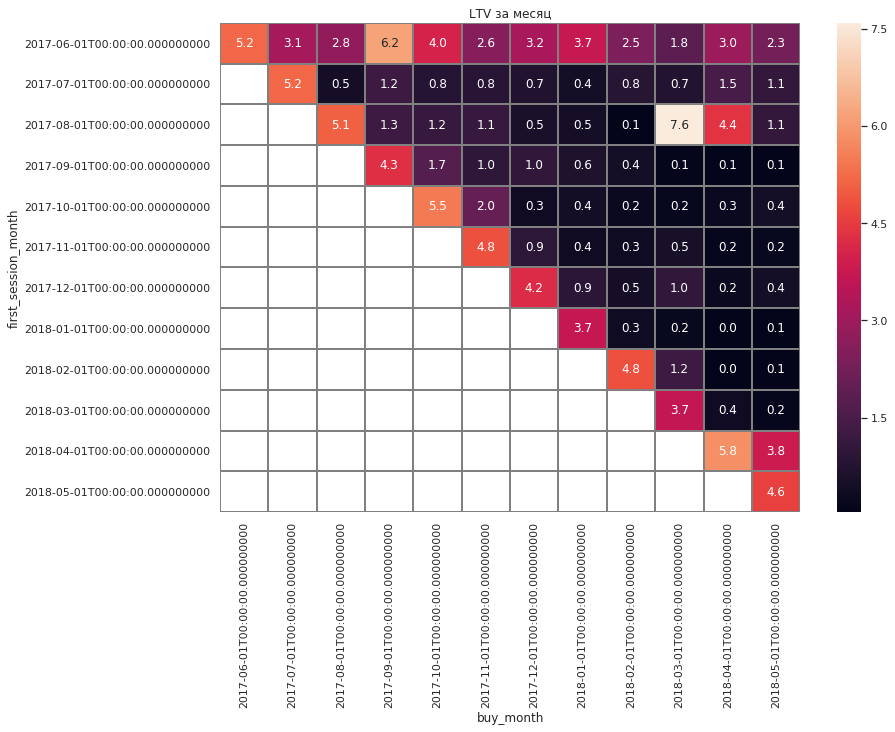

Источник 1
buy_month
2017-06-01    1.0
2017-07-01    1.5
2017-08-01    2.0
2017-09-01    2.5
2017-10-01    3.0
2017-11-01    3.5
2017-12-01    4.0
2018-01-01    4.5
2018-02-01    5.0
2018-03-01    5.5
2018-04-01    6.0
2018-05-01    6.5
dtype: float64
first_session_month
2017-06-01    6.5
2017-07-01    6.0
2017-08-01    5.5
2017-09-01    5.0
2017-10-01    4.5
2017-11-01    4.0
2017-12-01    3.5
2018-01-01    3.0
2018-02-01    2.5
2018-03-01    2.0
2018-04-01    1.5
2018-05-01    1.0
dtype: float64
Источник 2


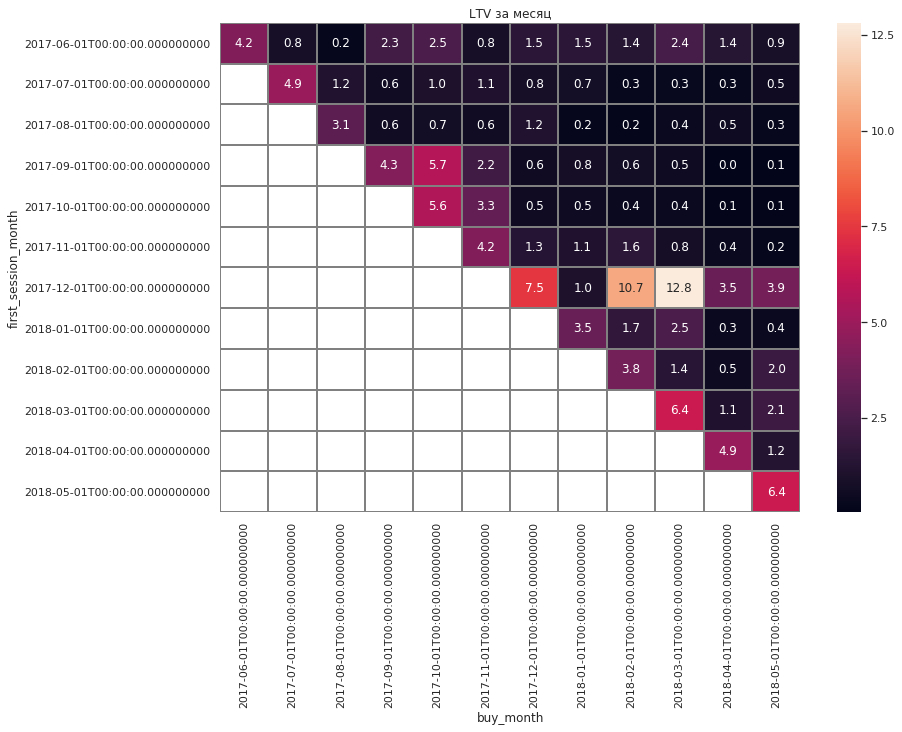

Источник 2
buy_month
2017-06-01    1.0
2017-07-01    1.5
2017-08-01    2.0
2017-09-01    2.5
2017-10-01    3.0
2017-11-01    3.5
2017-12-01    4.0
2018-01-01    4.5
2018-02-01    5.0
2018-03-01    5.5
2018-04-01    6.0
2018-05-01    6.5
dtype: float64
first_session_month
2017-06-01    6.5
2017-07-01    6.0
2017-08-01    5.5
2017-09-01    5.0
2017-10-01    4.5
2017-11-01    4.0
2017-12-01    3.5
2018-01-01    3.0
2018-02-01    2.5
2018-03-01    2.0
2018-04-01    1.5
2018-05-01    1.0
dtype: float64
Источник 3


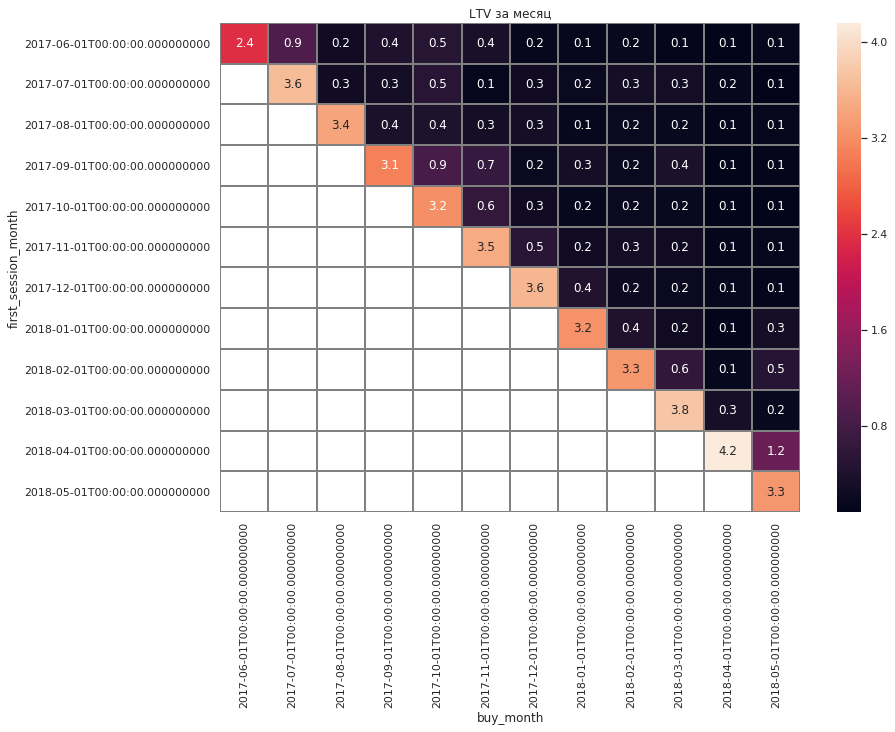

Источник 3
buy_month
2017-06-01    1.0
2017-07-01    1.5
2017-08-01    2.0
2017-09-01    2.5
2017-10-01    3.0
2017-11-01    3.5
2017-12-01    4.0
2018-01-01    4.5
2018-02-01    5.0
2018-03-01    5.5
2018-04-01    6.0
2018-05-01    6.5
dtype: float64
first_session_month
2017-06-01    6.5
2017-07-01    6.0
2017-08-01    5.5
2017-09-01    5.0
2017-10-01    4.5
2017-11-01    4.0
2017-12-01    3.5
2018-01-01    3.0
2018-02-01    2.5
2018-03-01    2.0
2018-04-01    1.5
2018-05-01    1.0
dtype: float64
Источник 5


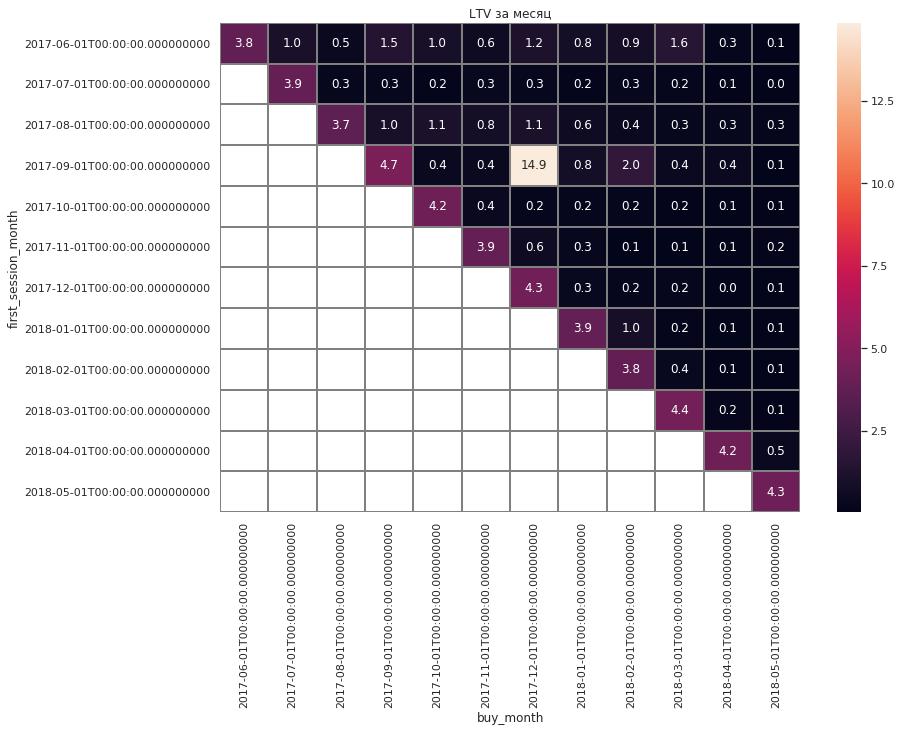

Источник 5
buy_month
2017-06-01    1.0
2017-07-01    1.5
2017-08-01    2.0
2017-09-01    2.5
2017-10-01    3.0
2017-11-01    3.5
2017-12-01    4.0
2018-01-01    4.5
2018-02-01    5.0
2018-03-01    5.5
2018-04-01    6.0
2018-05-01    6.5
dtype: float64
first_session_month
2017-06-01    6.5
2017-07-01    6.0
2017-08-01    5.5
2017-09-01    5.0
2017-10-01    4.5
2017-11-01    4.0
2017-12-01    3.5
2018-01-01    3.0
2018-02-01    2.5
2018-03-01    2.0
2018-04-01    1.5
2018-05-01    1.0
dtype: float64
Источник 4


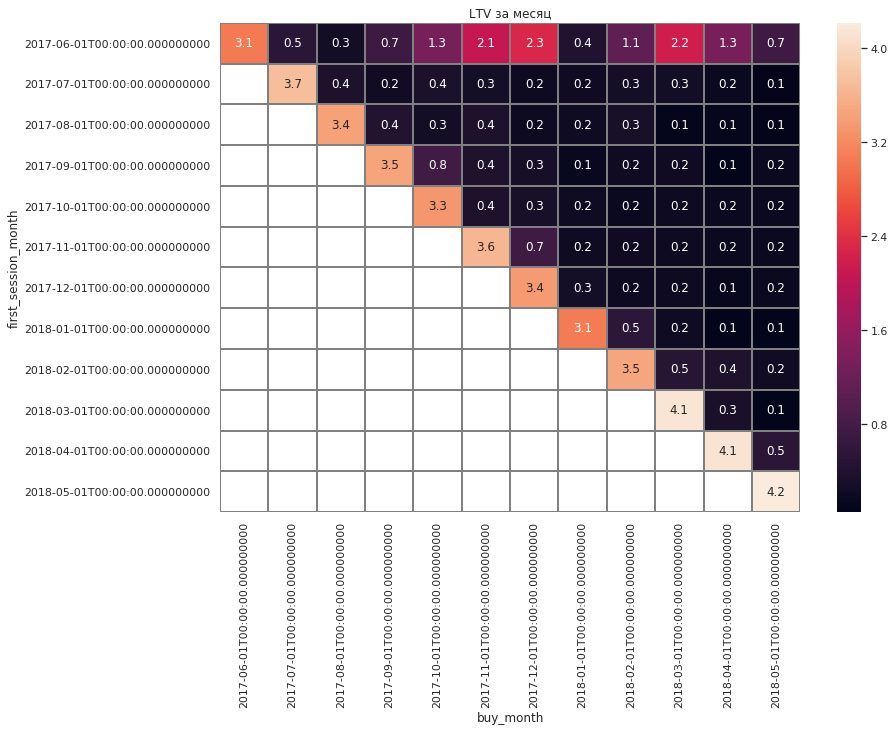

Источник 4
buy_month
2017-06-01    1.0
2017-07-01    1.5
2017-08-01    2.0
2017-09-01    2.5
2017-10-01    3.0
2017-11-01    3.5
2017-12-01    4.0
2018-01-01    4.5
2018-02-01    5.0
2018-03-01    5.5
2018-04-01    6.0
2018-05-01    6.5
dtype: float64
first_session_month
2017-06-01    6.5
2017-07-01    6.0
2017-08-01    5.5
2017-09-01    5.0
2017-10-01    4.5
2017-11-01    4.0
2017-12-01    3.5
2018-01-01    3.0
2018-02-01    2.5
2018-03-01    2.0
2018-04-01    1.5
2018-05-01    1.0
dtype: float64
Источник 9


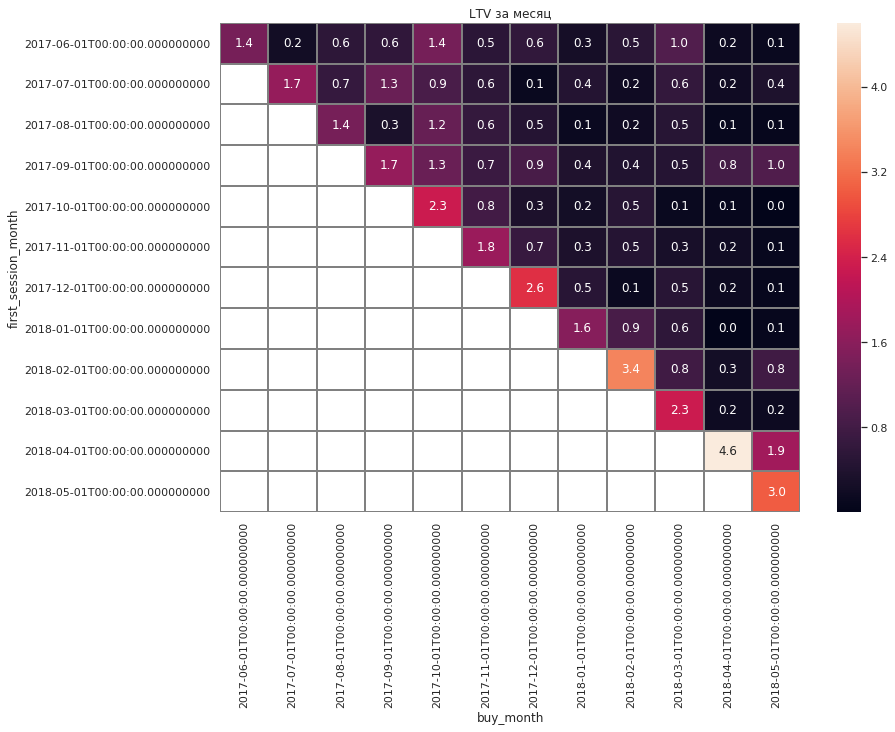

Источник 9
buy_month
2017-06-01    1.0
2017-07-01    1.5
2017-08-01    2.0
2017-09-01    2.5
2017-10-01    3.0
2017-11-01    3.5
2017-12-01    4.0
2018-01-01    4.5
2018-02-01    5.0
2018-03-01    5.5
2018-04-01    6.0
2018-05-01    6.5
dtype: float64
first_session_month
2017-06-01    6.5
2017-07-01    6.0
2017-08-01    5.5
2017-09-01    5.0
2017-10-01    4.5
2017-11-01    4.0
2017-12-01    3.5
2018-01-01    3.0
2018-02-01    2.5
2018-03-01    2.0
2018-04-01    1.5
2018-05-01    1.0
dtype: float64
Источник 10


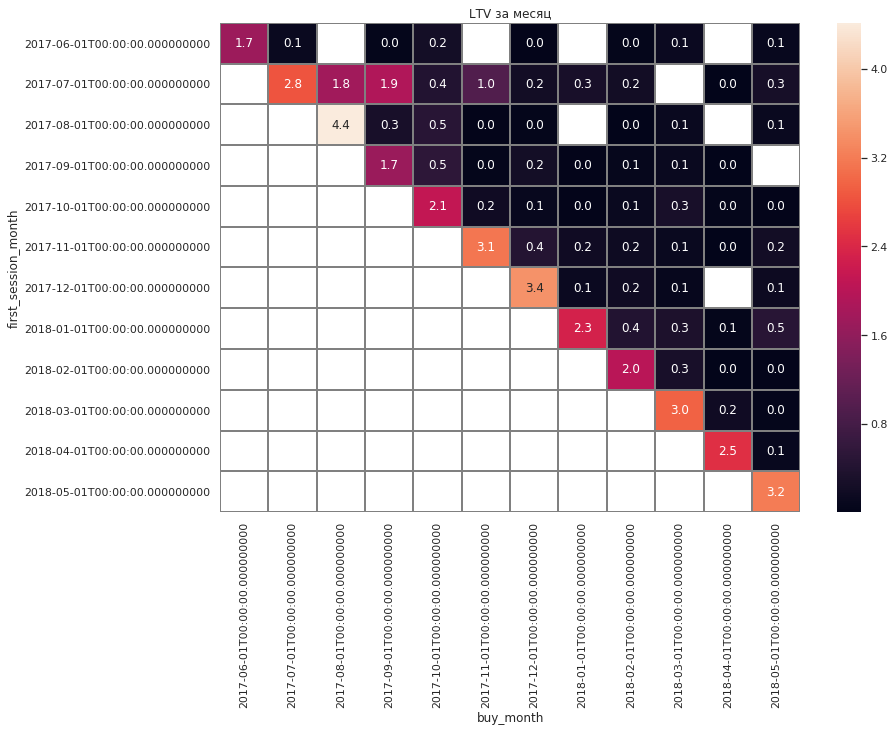

Источник 10
buy_month
2017-06-01    1.000000
2017-07-01    1.500000
2017-08-01    1.500000
2017-09-01    2.250000
2017-10-01    2.800000
2017-11-01    3.000000
2017-12-01    3.714286
2018-01-01    3.666667
2018-02-01    4.555556
2018-03-01    4.666667
2018-04-01    5.000000
2018-05-01    5.545455
dtype: float64
first_session_month
2017-06-01    4.5
2017-07-01    5.5
2017-08-01    4.5
2017-09-01    4.5
2017-10-01    4.5
2017-11-01    4.0
2017-12-01    3.0
2018-01-01    3.0
2018-02-01    2.5
2018-03-01    2.0
2018-04-01    1.5
2018-05-01    1.0
dtype: float64


In [58]:
source_list = list(orders_log['first_source_id'].unique())
for i in source_list:
    print('Источник', i)
    source_i = orders_log.query('first_source_id == @i')

    si_cohort_size = source_i.groupby('first_session_month').agg({'uid': 'nunique'}).reset_index()

    si_cohort_grouped = source_i.groupby(['first_session_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index()
    costs_gruoped = costs.groupby(['costs_month','source_id']).agg({'costs' : 'sum'}).reset_index()
    costs_for_si = costs_gruoped.query('source_id == @i')
    si_cohort_grouped = pd.merge(si_cohort_grouped, costs_for_si, left_on = 'first_session_month', right_on = 'costs_month')
    si_cohort_grouped = pd.merge(si_cohort_grouped, si_cohort_size, on = 'first_session_month')
    si_cohort_grouped['ltv'] = si_cohort_grouped['revenue']/ si_cohort_grouped['uid']
    
    for_heatmap = si_cohort_grouped.pivot_table(index='first_session_month', 
        columns='buy_month', 
        values='ltv', 
        aggfunc='mean')
    plt.figure(figsize=(13, 9))
    plt.title('LTV за месяц')
    sns.heatmap(for_heatmap, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
    plt.show()
    si_cohort_grouped['cac'] = si_cohort_grouped['revenue']/ si_cohort_grouped['uid']
    si_cohort_grouped['roi'] = si_cohort_grouped['ltv']/si_cohort_grouped['cac']
    si_roi = si_cohort_grouped.pivot_table(index='first_session_month', 
        columns='buy_month', 
        values='roi', 
        aggfunc='sum')
    print('Источник', i)
    print(si_roi.cumsum(axis=1).mean(axis=0))
    print(si_roi.cumsum(axis=1).mean(axis=1))

Исходя из расчитанного ROI для каждого ресурса, все источники окупаются в первый месяц. При этом Хуже всего для у источника с 'source_id' = 10. Для некоторых источников есть очевидные пики доходности в некоторых когортах. Это требует подробного изучения для планирования дальнейшей маркетинговой стратегии.

In [59]:
pref_device = visits_log.groupby(['uid']).agg({'device': 'first'}).reset_index()
orders_log = pd.merge(orders_log, pref_device, on = 'uid')
device_list = list(orders_log['device'].unique())
device_list

['desktop', 'touch']

In [60]:

for i in device_list:
    print('Устройство', i)
    source_i = orders_log.query('device == @i')

    si_cohort_size = source_i.groupby('first_session_month').agg({'uid': 'nunique'}).reset_index()

    si_cohort_grouped = source_i.groupby(['first_session_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index()
    costs_gruoped = costs.groupby(['costs_month','source_id']).agg({'costs' : 'sum'}).reset_index()
    costs_for_si = costs_gruoped
    si_cohort_grouped = pd.merge(si_cohort_grouped, costs_for_si, left_on = 'first_session_month', right_on = 'costs_month')
    si_cohort_grouped = pd.merge(si_cohort_grouped, si_cohort_size, on = 'first_session_month')
    si_cohort_grouped['ltv'] = si_cohort_grouped['revenue']/ si_cohort_grouped['uid']
    
    display(si_cohort_grouped.pivot_table(index='first_session_month', 
        columns='buy_month', 
        values='ltv', 
        aggfunc='mean'))
    si_cohort_grouped['cac'] = si_cohort_grouped['revenue']/ si_cohort_grouped['uid']
    si_cohort_grouped['roi'] = si_cohort_grouped['ltv']/si_cohort_grouped['cac']
    si_roi = si_cohort_grouped.pivot_table(index='first_session_month', 
        columns='buy_month', 
        values='roi', 
        aggfunc='sum')
    print('Устройство', i)
    print(si_roi.cumsum(axis=1).mean(axis=0))
    print(si_roi.cumsum(axis=1).mean(axis=1))

Устройство desktop


buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_session_month,,,,,,,,,,,,
2017-06-01,3.349535,0.901427,0.603049,1.727857,1.578269,1.161214,1.492888,0.962470,1.021844,1.548691,0.947738,0.474865
2017-07-01,NaN,3.941863,0.443489,0.546678,0.559890,0.428616,0.369700,0.313420,0.308691,0.312272,0.343668,0.281176
2017-08-01,NaN,NaN,3.570582,0.666397,0.733761,0.599788,0.650330,0.326530,0.279339,0.447553,0.222596,0.222345
2017-09-01,NaN,NaN,NaN,3.762081,1.055529,0.622910,4.652878,0.541984,0.820599,0.302518,0.203297,0.141842
2017-10-01,NaN,NaN,NaN,NaN,3.916389,0.696537,0.293506,0.248409,0.245197,0.211635,0.129898,0.147482
2017-11-01,NaN,NaN,NaN,NaN,NaN,3.734928,0.761376,0.337339,0.397204,0.294954,0.184931,0.185687
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.299611,0.464935,1.400733,1.646418,0.507361,0.547718
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.422505,0.673583,0.443755,0.103657,0.148178
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.641368,0.732030,0.269226,0.515581


Устройство desktop
buy_month
2017-06-01     7.0
2017-07-01    10.5
2017-08-01    14.0
2017-09-01    17.5
2017-10-01    21.0
2017-11-01    24.5
2017-12-01    28.0
2018-01-01    31.5
2018-02-01    35.0
2018-03-01    38.5
2018-04-01    42.0
2018-05-01    45.5
dtype: float64
first_session_month
2017-06-01    45.5
2017-07-01    42.0
2017-08-01    38.5
2017-09-01    35.0
2017-10-01    31.5
2017-11-01    28.0
2017-12-01    24.5
2018-01-01    21.0
2018-02-01    17.5
2018-03-01    14.0
2018-04-01    10.5
2018-05-01     7.0
dtype: float64
Устройство touch


buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_session_month,,,,,,,,,,,,
2017-06-01,2.513706,1.333540,0.249482,0.253665,0.591905,0.435072,0.330352,0.290373,0.231346,0.341346,0.260331,0.922133
2017-07-01,NaN,3.792581,0.585957,0.267656,0.233183,0.405548,0.247161,0.207763,0.386409,0.311398,0.062323,0.058925
2017-08-01,NaN,NaN,3.135645,0.495401,0.495331,0.323972,0.234564,0.254216,0.173937,2.282962,1.812648,0.263763
2017-09-01,NaN,NaN,NaN,3.311223,2.127186,1.050452,0.311692,0.155645,0.183116,0.420503,0.076616,0.152194
2017-10-01,NaN,NaN,NaN,NaN,3.326623,1.590156,0.319518,0.201995,0.117575,0.139270,0.107145,0.159009
2017-11-01,NaN,NaN,NaN,NaN,NaN,3.604022,0.531802,0.338338,0.215489,0.171941,0.066229,0.083827
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,3.035386,0.452961,0.233871,0.499725,0.106364,0.250992
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.916984,0.653855,0.287129,0.084484,0.312226
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.397058,0.357685,0.098441,0.093183


Устройство touch
buy_month
2017-06-01     7.0
2017-07-01    10.5
2017-08-01    14.0
2017-09-01    17.5
2017-10-01    21.0
2017-11-01    24.5
2017-12-01    28.0
2018-01-01    31.5
2018-02-01    35.0
2018-03-01    38.5
2018-04-01    42.0
2018-05-01    45.5
dtype: float64
first_session_month
2017-06-01    45.5
2017-07-01    42.0
2017-08-01    38.5
2017-09-01    35.0
2017-10-01    31.5
2017-11-01    28.0
2017-12-01    24.5
2018-01-01    21.0
2018-02-01    17.5
2018-03-01    14.0
2018-04-01    10.5
2018-05-01     7.0
dtype: float64


Нет подтверждения о различии окупаемости клиента по source_id и device

In [61]:
costs_sum = costs.groupby('costs_month')['costs'].sum()
report_new = pd.merge(report, costs_sum, left_on='first_order_month', right_on='costs_month')
costs_sum

costs_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

In [62]:
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new.head()

,first_order_month,n_buyers,buy_month,revenue,gp,age,ltv,costs,cac,romi
0,2017-06-01,1776,2017-06-01,8278.29,8278.29,0,4.661199,18015.0,10.143581,0.459522
1,2017-06-01,1776,2017-07-01,936.98,936.98,1,0.527579,18015.0,10.143581,0.052011
2,2017-06-01,1776,2017-08-01,840.07,840.07,2,0.473012,18015.0,10.143581,0.046632
3,2017-06-01,1776,2017-09-01,1884.14,1884.14,3,1.060890,18015.0,10.143581,0.104587
4,2017-06-01,1776,2017-10-01,2021.90,2021.90,4,1.138457,18015.0,10.143581,0.112234


In [63]:
output_cac = report_new.pivot_table(
        index='first_order_month',  
        values='cac', 
        aggfunc='mean')
output_cac

,cac
first_order_month,
2017-06-01,10.143581
2017-07-01,10.780491
2017-08-01,11.937482
2017-09-01,10.567611
2017-10-01,9.402765
2017-11-01,10.538749
2017-12-01,9.887832
2018-01-01,11.106203
2018-02-01,10.046985


In [64]:

print(output_cac.mean(axis=1).mean())

10.265917761857331


Средняя стоимость привлечения клиента очень разнится от когорт к когорте. Например, наименьшая CAC у когорты 2018-05-01 - 8.30, а наибольшая у когорты 2017-08-01 -  11.94.

Общая средняя  CAC составляет 10.26. 

In [65]:
output_romi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output_romi.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.46,0.51,0.56,0.66,0.77,0.85,0.95,1.02,1.08,1.14,1.21,1.23
2017-07-01,0.56,0.59,0.66,0.70,0.72,0.74,0.75,0.77,0.78,0.80,0.82,NaN
2017-08-01,0.43,0.48,0.52,0.55,0.60,0.62,0.64,0.68,0.70,0.72,NaN,NaN
2017-09-01,0.50,0.62,0.67,1.08,1.13,1.19,1.27,1.29,1.31,NaN,NaN,NaN
2017-10-01,0.53,0.58,0.61,0.62,0.64,0.65,0.66,0.68,NaN,NaN,NaN,NaN
2017-11-01,0.49,0.53,0.55,0.58,0.60,0.60,0.62,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.48,0.51,0.61,0.73,0.77,0.81,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.37,0.40,0.43,0.44,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.42,0.44,0.45,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Когорта 2017-06-01 окупилась за 6 месяцев. В то время, как когорта 2017-09-01 окупилась за 3 месяца, а когорта 2017-07-01 не окупилась даже к 10 месяцу жизни. 

In [66]:
output_romi.cumsum(axis=1).mean(axis=0)

age
0     0.475625
1     0.516553
2     0.561528
3     0.648209
4     0.708811
5     0.781758
6     0.815754
7     0.886581
8     0.969546
9     0.889213
10    1.012360
11    1.232788
dtype: float64

В среднем когорты окупаются к 8 месяцу. 

Наиболее затратными по привлечению клиентов являются когорты 2017-08-01 и 2018-01-01. Когорта 2017-08-01 не окупилась на половину до окончания периода исследования, несмотря на 9 месяцев существования.
Высокие маркетинговые траты не означают высокую прибыль от пользователей. Например, сравнивая LTV за первые 6 месяце жизни, получаем:
LTV для когорты 2017-06-01  1.02, СAC  10.14
LTV для когорты 2017-08-01 0.22, CAC 11.93
LTV для когорты 2017-11-01  0.12, CAC 10.54
Наибольшее LTV при наименьших затратах в рассматриваемой тройке когорт.
Некоторые рекламные ресурсы так и не окупились за счет привлеченных пользователей. 

## 3. Выводы

Bсе графы, содержащие данные о датах и времени, сохранены в формате 'object'. Это затрудняет работу с данными.
В датафрейме minus_and_null_duration сохранены логи посещений с отрицательной и нулевой длительностью - выяснить, где происходит ошибка, как получается, что время окончания сессии происходит раньше, чем само начало сессии. Из гистограммы видно, что редко случаются сессии длиной более 5000 сек. Скорее всего здесь тоже имеет место ошибка. Для дальнейшего анализа будут взяты данные с длительностью сессии более 0 и менее 5000 сек.


- Песетителей в день: 794.2802197802198
- Песетителей в неделю: 5036.509433962264
- Песетителей в месяц: 20551.416666666668

- Сессий в день: 853
- Средняя длительность сессии: 60.0 сек.


 В первые месяцы количество уникальных пользователей в 16 раз больше, чем во второй и последующие. Так же видно, что с октября 2017 по март 2018 - пользователей было очевидно больше, чем в оставл=шиеся (более 20 тыс уникальных пользователей). Пик интереса приходится на октябрь и ноябрь 2017.
 Коэфициент удержания (Retention Rate) низкий. ЭТо связано с тем, что большое число пользователей, привлеченных в первый месяц не возвращается. Можно предположить, что основная проблема не в привлечении новых клиентов, а в очень низкой конверсии посетителей в клиентов.
 Коэффициент оттока (Churn Rate) показывает, что от месяца к месяцу коэффициент пользователей уменьшается. Положительных значений очень мало. Единственной когортой, показавшей рост количества пользователей в последний месяц (май 2018) - это самая старая когорта (июня 2017). Есть какой то бонус для пользователей, вернувшихся через год? В апреле 2018 все когорты показали снижение количества пользователей - от 23,3 до 56,8% Подтверждается предположение о проблеме удержаия пользователей.
 Подавляющее большинство покупок совершается в первый день после регистрации (медиана пролегает на 382 минуте после первого визита). А метод mode() показывает, что большинство покупок совершается в первую минуту после регистрации.
 
 
- Средний чек за весь период  5.07
- Среднее количество покупок за месяц: 3762.08
 
 
 Средний чек для всех когорт во все периоды жизни примерно одинаковый, за исключением декабря 2017 года для когорты 2017-09-01
 По итоговым LTV видно, что когорта '2017-09-01' сравнялась с когортой '2017-06-01', несмотря на разницу в возрасте этих когорт. Что стало причиной повышенного количества покупок для когорты '2017-09-01' в марте 2018 года? И почему с 3го месяца жизни клиенты этой когорты тратят больше денег, чем клиенты других когорт. Так же интересно, с чем связан пик покупок в декабре 2017 для когорты '2017-09-01'? (средний чек для этой когорты в декабре составил 38.4, при общем среднем чеке в 5.1 - возможно, была новогодняя акция?)
 
Общая средняя стоимость одного клиента  - 10.3
 
- Всего денег потратили за год: 329131.62
- Всего денег заработали за год: 238413.74


Больше всего денег за весь период вложено в ресурс 3. Больше всего денег потрачено на маркетинг в декабре 2017. (Новогодние праздники) 

##### Для отдела маркетинга: пересмотреть распределение расходов на рекламные ресурсы.

По итоговым суммам за год ресурсы с ID 3, 4, 9, 10 не окупились. В то время как ресурсы 1, 2, 5 вышли в плюс. 
Исходя из расчитанного ROI для каждого ресурса, все источники окупаются в первый месяц. При этом Хуже всего для у источника с 'source_id' = 10. Для некоторых источников есть очевидные пики доходности в некоторых когортах. Это требует подробного изучения для планирования дальнейшей маркетинговой стратегии. При этом все ресурсы используются с начала исследуемого периода.
##### Для отдела маркетинга: при маркетинге учитывать, что чаще и дольше используют device типа desktop

Когорта 2017-06-01 окупилась за 6 месяцев. В то время, как когорта 2017-09-01 окупилась за 3 месяца, а когорта 2017-07-01 не окупилась даже к 10 месяцу жизни.

##### Для отдела маркетинга: изучить когорту 2017-09-01 - почему так быстро окупилась.
В этой когорте так же был самый большой средний чек в декабре 2017 - один крупный заказ? Или особенная акция?

В среднем когорт окупаются к 8 месяцу. А если не окупились к 8му - то обязательно окупятся к 10 (но не окупятся к 9).